<a href="https://colab.research.google.com/github/herysedra/ady_cov/blob/master/scr/modely_RP/R_tabilao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!pip install pynverse

  Created wheel for pynverse: filename=pynverse-0.1.4.4-cp36-none-any.whl size=6350 sha256=2662c23ab57a656fe56abd70d7b63ae58b9de3376120040138c397724090eaf1
  Stored in directory: /root/.cache/pip/wheels/80/ab/86/ec93f37613f012ba3e65c2bbd67e5c54cbc00d237574100c24
Successfully built pynverse


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib
import pickle

import datetime
import time
from datetime import date

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns

from numpy import log,exp
from numpy.random import multinomial
from scipy.stats import uniform, gamma, gengamma, poisson, nbinom, expon
from scipy.integrate import quad

from mpl_toolkits.mplot3d.axes3d import Axes3D, get_test_data
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from pynverse import inversefunc

tilyvoa = pd.read_csv("/content/drive/My Drive/data/tilyvoa.csv")

mdg_databe = pd.read_csv("/content/drive/My Drive/data/databe mdg.csv")

#tilyvoa.set_index('Daty', inplace=True)

tilyvoafar = tilyvoa.groupby('Faritra')
tilyvoamdg = tilyvoafar.get_group('Madagasikara')
tilyvoamdg.set_index('Daty', inplace=True)

tilyvoamdg.index = pd.to_datetime(tilyvoamdg.index)

tilyvoatana = tilyvoafar.get_group('Antananarivo')
tilyvoatana.set_index('Daty', inplace=True)

tilyvoatana.index = pd.to_datetime(tilyvoatana.index)

tilyvoatoa = tilyvoafar.get_group('Toamasina')
tilyvoatoa.set_index('Daty', inplace=True)

tilyvoatoa.index = pd.to_datetime(tilyvoatoa.index)


path_to_save = '/content/drive/My Drive/sary/'
path_data = '/content/drive/My Drive/data/'

In [0]:
# Voa vaovao (observed incidence)
Ivao = tilyvoamdg['Voatomb']

dIvao = pd.DataFrame(data =Ivao)

dIvao['Datint'] = range(len(Ivao))


# Hoan'ny taha sorisoritry ny fifindrana (infectioness profile distribution)

daty_data_manom = datetime.date(2020,4,1)
daty_data_mifar = datetime.date(2020,6,5)

datyt = daty_data_mifar - datetime.timedelta(days = 1)

format_date = lambda date_py: '{}-{}-{}'.format(date_py.year, date_py.month, date_py.day)
datyf_data_manom = format_date(daty_data_manom)
datyf_data_mifar = format_date(daty_data_mifar)

# Discretization of the serial interval distribution

#Tombana mialoha (prior distributions)
#si_sh = 1/(0.62**2) # Report 13
#si_sc = 6.5/si_sh

si_sh = (6.48**2)/(3.83**2) # Planning tool: Short-term forecasts
si_sc = 6.48/si_sh

def discr_si(t):
  if t == 0:
    discrsi = 0
  elif t == 1:
    discrsi = gengamma.cdf(3/2, si_sh, 1, loc = 0, scale = si_sc)
  else:
    discrsi = gengamma.cdf(t+1/2, si_sh, 1, loc = 0, scale = si_sc) - gengamma.cdf(t-1/2, si_sh, 1, loc = 0, scale = si_sc)
  return discrsi

#discr_si1 = gengamma.cdf(3/2, si_sh, 1, loc = 0, scale = si_sc)

# 1 The total incidence over a generic window (t-k+1,t)
# Ireh(t,k) = sum(i = 0 to k-1) Ivao(t - i))

def Ireh(t,k):
  Irehv = 0
  for i in range(k):
    Irehv = Irehv + dIvao['Voatomb'].loc[format_date(t - datetime.timedelta(days = i))]
  return Irehv

# 2 Tool to compute the total infectiousness over a generic window (t-k+1,t)
# Isi(t,k) = sum(i=0 to k-1) Ivao(t - i)*discr_si(i)

# The definition of Isi(t,k) does not include the term Ivao(t) for i = 0 (because discr_si(0) =0) 
# but include the last term Ivao(t - k + 1)*discr_si(k - 1) for i = k-1. 

def Isi(t,k):
  Ivaosi = 0
  for i in range(k):
    Ivaosi = Ivaosi + dIvao['Voatomb'].loc[format_date(t - datetime.timedelta(days = i))]*discr_si(i)
  return Ivaosi

# The total infectiousness before t

# lsi(t) := sum(i=0 to t-1) Ivao(t - i)*discr_si(i)

def lsi(t):
  return Isi(t, (t - daty_data_manom).days +1)

  # for checking, take for example t = daty_data_manom + datetime.timedelta(days = 3)

# 3 The sum of total infectiousness before t over a generic window (t-k+1,t)

def tlsi(t,k):
  tlsi = 0
  for i in range(k):
    tlsi = tlsi + lsi(t - datetime.timedelta(days = k))
  return tlsi

# 4 The shape parameters of the posterior predictive negative binomial of I(t+1)

# pnb(t,k) = Isi(t+1, t - daty_data_manom + 2)*(1/si_sc + Isi(t,k))/(1 + si(t+1, t - daty_data_manom + 2)*(1/si_sc + Isi(t,k)))

def pnb(t,k):
  return lsi(t+datetime.timedelta(days = 1))*(1/si_sc + tlsi(t,k))/(1 + lsi(t+datetime.timedelta(days = 1))*(1/si_sc + tlsi(t,k)))

# pnb(t,k) dia ny taha herjika hoan'ny NB hoan'ny I(t+1).

# 5 Use the pmf of the posterior predictive negative binomial to compute
# each additive contribution at time s then for-loop for s in the time interval

def lpr(t,k):
  return -np.log(nbinom.pmf(dIvao['Voatomb'].loc[format_date(t + datetime.timedelta(days = 1))], si_sh + Ireh(t,k), pnb(t,k)))


In [8]:
# APE9_part1 

# for i in range(8):
# t = t_mif - i - 1
# k = 9

APEt91 = []
Prt91 = []

APE91 = 0

for i in range(round(((daty_data_mifar - daty_data_manom).days + 1)/2) - 1):
  t = daty_data_mifar - datetime.timedelta(days = i+1) 
  k = round(((daty_data_mifar - daty_data_manom).days + 1)/2)
  APE91 = APE91 + lpr(t,k)
  APEt91.append((lpr(t,k),t))
  Prt91.append(expon.pdf(lpr(t,k)))

print('For k = 9, APE91 =', APE91)
print('APEt91 =', APEt91)
print('Prt91 =', Prt91)

# APE9_part2 

# for i in range(9):
# t = t_mif - 1 - 9 + 1 - i
# k = t_mif - t - 2*i
APEt92 = []
Prt92 = []

APE92 = 0
for i in range(round(((daty_data_mifar - daty_data_manom).days + 1)/2)-1):
  t = daty_data_mifar - datetime.timedelta(days = 1) - datetime.timedelta(days = ((daty_data_mifar - daty_data_manom).days + 1)/2) + datetime.timedelta(days = 1) - datetime.timedelta(days = i)
  k = (daty_data_mifar - t - datetime.timedelta(days = 2*i)).days
  APE92 = APE92 + lpr(t,k) 
  APEt92.append((lpr(t,k) ,t,k))
  Prt92.append(expon.pdf(lpr(t,k)))

print('For k = 9, APE92 =', APE92)
print('APEt92=', APEt92)
print('Prt92=', Prt92)

# For t_man such that Ivao(t_man) = Ivao(t_man + 1) = 0, lsi(t_man + 1) = tlsi(t_man + 1, 2) = Ireh(t_man + 1, 2) = 0
# so that pnb(t_man + 1, 2) = 0 and 

For k = 9, APE91 = 3214.944481870216
APEt91 = [(43.69252444726611, datetime.date(2020, 6, 4)), (161.31738925794204, datetime.date(2020, 6, 3)), (230.36549104828242, datetime.date(2020, 6, 2)), (49.83456359262556, datetime.date(2020, 6, 1)), (113.61903145219975, datetime.date(2020, 5, 31)), (96.22647827214911, datetime.date(2020, 5, 30)), (221.99041879721167, datetime.date(2020, 5, 29)), (150.08694248099073, datetime.date(2020, 5, 28)), (170.43167519567032, datetime.date(2020, 5, 27)), (94.87571354531117, datetime.date(2020, 5, 26)), (192.00141381694235, datetime.date(2020, 5, 25)), (53.353369434917425, datetime.date(2020, 5, 24)), (175.74551291926275, datetime.date(2020, 5, 23)), (183.66288476525847, datetime.date(2020, 5, 22)), (201.9047590762397, datetime.date(2020, 5, 21)), (153.59979307793293, datetime.date(2020, 5, 20)), (219.8286236102796, datetime.date(2020, 5, 19)), (11.765537517594762, datetime.date(2020, 5, 18)), (74.11558742761665, datetime.date(2020, 5, 17)), (88.1262188117

In [9]:
# APEk part 1 for k =/= 9

# for i in range(t_mif - t_man -j)

APEk1 = []
for j in range(2,9):
  APEj1 = 0
  for i in range(round(((daty_data_mifar - daty_data_manom).days) - j)):
    t = daty_data_mifar - datetime.timedelta(days = i+1) 
    k = j
    APEj1 = APEj1 + lpr(t,k)
  APEk1.append(APEj1)

print('APEk1 =', APEk1)

# APEk part 2 for k =/= 9

Prk2 = []

APEk2 = []

for j in range(2,9):
  APEj2 = 0
  for i in range(j-1):
    t = daty_data_manom + datetime.timedelta(days = j - i - 1)
    k = j - i
    APEj2 = APEj2 + lpr(t,k)
  APEk2.append(APEj2)

print('APEk2 =', APEk2)

APEk1 = [4132.823704520315, 4128.762045738607, 4086.0998611050827, 4042.4790863032517, 3986.1976461193804, 3921.81668873378, 3846.934332205393]
APEk2 = [13.516925667669307, 30.900952107794467, 39.01733994602137, 46.496411218149625, 55.67711171167671, 71.44087892157246, 88.13483638425814]


In [10]:
# APEk for k = 2,...,8

APEk = [x + y for x, y in zip(APEk1, APEk2)]

# APE9
APE9 = APE91 + APE92

print('APE9 =', APE9)
print('APEk =', APEk)

APE9 = 4600.122731441907
APEk = [4146.340630187984, 4159.662997846402, 4125.1172010511045, 4088.9754975214014, 4041.874757831057, 3993.257567655353, 3935.069168589651]


In [11]:
# Prior Gamma distribution of Rt

Rtpr_sh = 0.1 # shape
Rtpr_sc = 0.1 # scale

# Posterior distribution for Rt

# Shape parameter :
def Rtps_sh(t):
   return Rtpr_sh + Ireh(t,8)

# Scale
def Rtps_sc(t):
  return 1/(1/Rtpr_sc + tlsi(t,8))

# mean
def Rtps_salan(t):
  return Rtps_sh(t)*Rtps_sc(t)

print("Salan'isa R hoan'ny", datyt, ':', Rtps_salan(datyt))

# The 95th and 5th percentiles of Rt

def perc95(t):
  return gengamma.ppf(0.95, Rtps_sh(t), 1, loc = 0, scale = Rtps_sc(t))

def perc05(t):
  return gengamma.ppf(0.05, Rtps_sh(t), 1, loc = 0, scale = Rtps_sc(t))

def Rtps_sal(t):
  return dIvao['Voatomb'].loc[format_date(t)]/lsi(t)

print("Salan'isa R hoan'ny", datyt, ':', Rtps_sal(datyt))

sal_Rt = []

for i in range(round(((daty_data_mifar - daty_data_manom).days) - 1)):
  t = daty_data_manom + datetime.timedelta(days = i+1)
  sal_Rt.append(Rtps_sal(t))

print(sal_Rt)


Salan'isa R hoan'ny 2020-06-04 : 1.3645048132332775
Salan'isa R hoan'ny 2020-06-04 : 1.2899130570593746
[53.256847466316856, 10.66164095428925, 0.9909931553400698, 4.055282043376579, 4.08568270994384, 2.739726961416723, 0.6192822978018055, 0.2689876857037221, 2.310922198393247, 0.24418410109684097, 0.239920126691579, 0.4939101561543066, 0.5262146917063841, 0.5705136370400189, 1.8656381215024023, 0.6436945369960159, 0.32653698635091033, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7291187072646956, 0.8980849161628417, 1.0553729492182238, 3.4933739056398005, 0.0, 0.0, 0.0, 4.574587035994357, 3.2573195857696655, 12.854632537132684, 0.0, 0.8381532639844691, 2.4895687848752677, 0.9410780709174675, 1.7305231233486709, 0.5352530918914943, 0.516203117661004, 3.892606848584887, 1.4308696711938929, 4.262207530448934, 3.1621315776842005, 1.1249858661848848, 5.374119114335724, 1.98205568528583, 1.373901645326583, 0.2622620983514971, 2.7690879370429182, 1.9305010526461484, 2.2043954819604044, 1.8138210866700728, 1.5

In [12]:
# Plotting

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, date_py.month)

daty_lst = []

salan_Rt = []
perc95_lst = []
perc05_lst = []

salan_Rt_dat = []
salan_Rt_perc_dat = []

for i in range(round(((daty_data_mifar - daty_data_manom).days) - 1-10)):
  t = daty_data_manom + datetime.timedelta(days = i+1+10)
  daty = formatf_date(t)
  daty_lst.append(daty)
  salan_Rt.append(Rtps_salan(t))
  perc95_lst.append(perc95(t))
  perc05_lst.append(perc05(t))
  salan_Rt_dat.append((Rtps_salan(t),t))
  salan_Rt_perc_dat.append((perc95(t),Rtps_salan(t),perc05(t),t))

salan_Rt_dat

[(1.9421548121903218, datetime.date(2020, 4, 12)),
 (1.4242264778380958, datetime.date(2020, 4, 13)),
 (0.978006285869579, datetime.date(2020, 4, 14)),
 (0.6603155256670573, datetime.date(2020, 4, 15)),
 (0.6725013483776445, datetime.date(2020, 4, 16)),
 (0.6315873420673509, datetime.date(2020, 4, 17)),
 (0.4154883066880769, datetime.date(2020, 4, 18)),
 (0.37650104263506046, datetime.date(2020, 4, 19)),
 (0.34837232399458073, datetime.date(2020, 4, 20)),
 (0.309001941969883, datetime.date(2020, 4, 21)),
 (0.2747127606974255, datetime.date(2020, 4, 22)),
 (0.23919103793994959, datetime.date(2020, 4, 23)),
 (0.11475444899243609, datetime.date(2020, 4, 24)),
 (0.08893603972309322, datetime.date(2020, 4, 25)),
 (0.08985631807498477, datetime.date(2020, 4, 26)),
 (0.180816330486306, datetime.date(2020, 4, 27)),
 (0.1905154159613157, datetime.date(2020, 4, 28)),
 (0.20669907106523255, datetime.date(2020, 4, 29)),
 (0.22923796971133267, datetime.date(2020, 4, 30)),
 (0.42648268210104456, dat

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


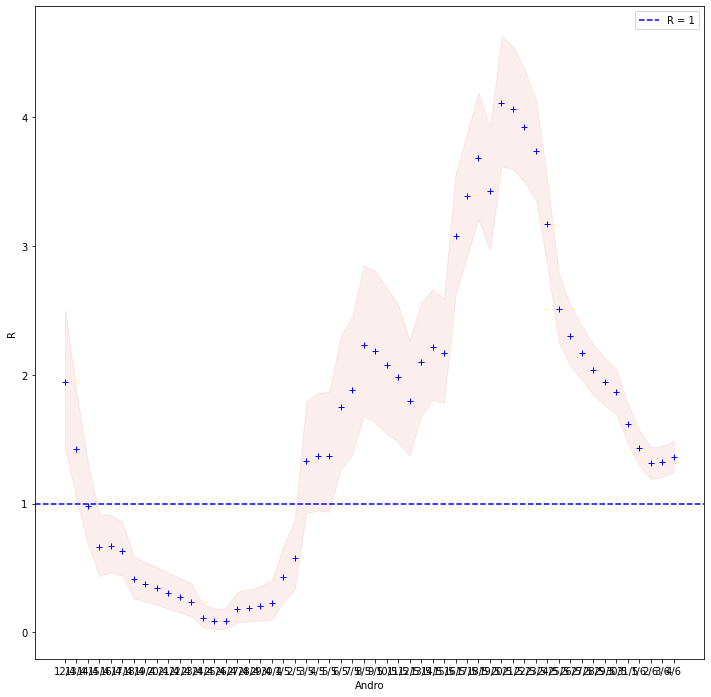

In [13]:
# Plotting

fig, ax = plt.subplots(figsize=(12, 12))

ax.plot(daty_lst, salan_Rt, 'b',  marker ="+",ls = 'None')
#ax.plot(daty_lst, sal_Rt, 'green',  marker =9,ls = 'None')
ax.axhline(y=1, color='b', linestyle='dashed', label ="R = 1")
ax.fill_between(daty_lst, perc05_lst, perc95_lst, alpha=0.08, color="tab:red")

ax.set(xlabel ='Andro', ylabel = "R")
ax.legend(loc= 'best')

plt.savefig(path_to_save+'R_2_4_2_6.eps')
plt.show()

In [0]:
  #shape
def func_sh(t):
    def Rtpsand_sh(a):
      return a + Ireh(t,8)
    return Rtpsand_sh
  # Scale
def func_sc(t):
    def Rtpsand_sc(b):
      return 1/(1/b + tlsi(t,8))
    return Rtpsand_sc

def funcsh_inv(t):
    def sh_invex(x):
      return (x + Ireh(t,8))/x
    return inversefunc(sh_invex)

def Rt_salan(t):
    ffunc_sh = func_sh(t)
    ffunc_sc = func_sc(t)
    ffuncsh_inv = funcsh_inv(t)
    return ffuncsh_inv(1/ffunc_sc(1))

# The 95th and 5th percentiles of Rt

def perc95(t):
    return gengamma.ppf(0.95, func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1))

def perc05(t):
    return gengamma.ppf(0.05, func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1))


In [15]:
# Plotting

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, date_py.month)

daty_lst = []
salan_Rt_lst = []
perc95_lst = []
perc05_lst = []


for i in range(round(((daty_data_mifar - daty_data_manom).days) - 1 -12)):
  t = daty_data_manom + datetime.timedelta(days = i+1 +12)
  daty = formatf_date(t)
  daty_lst.append(daty)
  perc95_lst.append(perc95(t))
  perc05_lst.append(perc05(t))
  salan_Rt_lst.append(Rt_salan(t))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero e

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


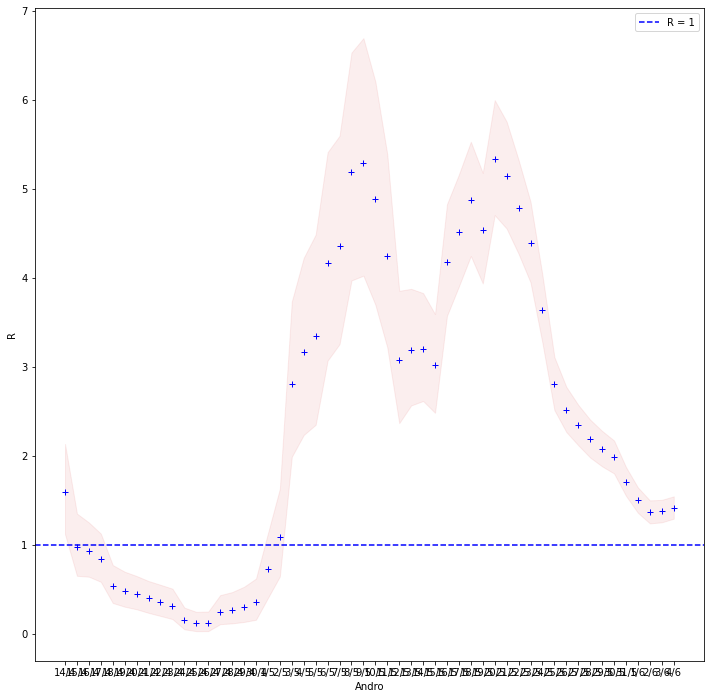

In [16]:
# Plotting

fig, ax = plt.subplots(figsize=(12, 12))

ax.plot(daty_lst, salan_Rt_lst, 'b',  marker ="+",ls = 'None')
#ax.plot(daty_lst, sal_Rt, 'green',  marker =9,ls = 'None')
ax.axhline(y=1, color='b', linestyle='dashed', label ="R = 1")
ax.fill_between(daty_lst, perc05_lst, perc95_lst, alpha=0.08, color="tab:red")

ax.set(xlabel ='Andro', ylabel = "R")
ax.legend(loc= 'best')

plt.savefig(path_to_save+'R_2_4_2_6.eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


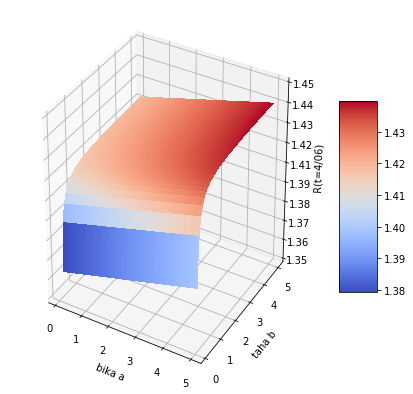

In [17]:
datyab = datetime.date(2020, 6, 4)

fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection='3d')

# Make data.
X = np.linspace(0.1,5,100)
Y = np.linspace(0.1,5,100)
X, Y = np.meshgrid(X, Y)
Z = func_sh(datyab)(X)*func_sc(datyab)(Y)
W = X*Y
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
#surf = ax.plot_surface(X, Y, W, cmap=cm.coolwarm,
 #                      linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(1.35, 1.45)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

ax.set(xlabel ='bika a', ylabel = "taha b", zlabel = 'R(t=4/06)')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.savefig(path_to_save+'Rtmena64.eps')

plt.show()

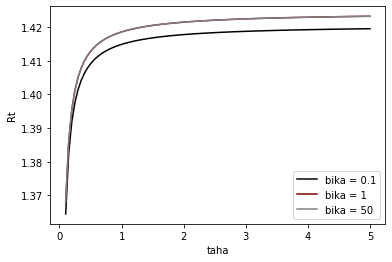

In [18]:
# Variation of discr_si1 with rapport to the shape parameter a

# 100 linearly spaced numbers
x = np.linspace(0.1,5,100)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plot the functions
plt.plot(x, func_sh(datyab)(0.1)*func_sc(datyab)(x), 'k', label ="bika = 0.1")
plt.plot(x, func_sh(datyab)(1)*func_sc(datyab)(x), 'maroon', label= 'bika = 1')
plt.plot(x, func_sh(datyab)(1)*func_sc(datyab)(x), 'grey', label= 'bika = 50')

ax.set(xlabel ='taha', ylabel = "Rt")
ax.legend(loc= 'lower right')

# show the plot
plt.show()

In [19]:
func_sh(datyab)(0.1)*func_sc(datyab)(0.6)

1.410996444648768

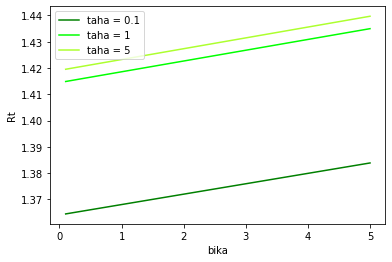

In [20]:
# Variation of R(t) with rapport to the shape prior parameter a

# 100 linearly spaced numbers
x = np.linspace(0.1,5,100)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plot the functions
plt.plot(x, func_sh(datyab)(x)*func_sc(datyab)(0.1), 'green', label ="taha = 0.1")
plt.plot(x, func_sh(datyab)(x)*func_sc(datyab)(1), 'lime',  label ="taha = 1")
plt.plot(x, func_sh(datyab)(x)*func_sc(datyab)(5), 'greenyellow', label ="taha = 5")

ax.set(xlabel ='bika', ylabel = "Rt")
ax.legend(loc= 'upper left')


# show the plot
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


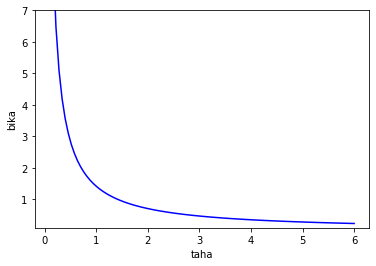

In [21]:
# Curve of (shape, scale) for which the prior mean is equal to the posterior mean

# 100 linearly spaced numbers
x = np.linspace(0.1,6,100)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plot the functions
plt.plot(x, funcsh_inv(datyab)(x/func_sc(datyab)(x)), 'blue')

ax.set_ylim(0.1, 7)
ax.set(xlabel ='taha', ylabel = "bika")



# show the plot
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


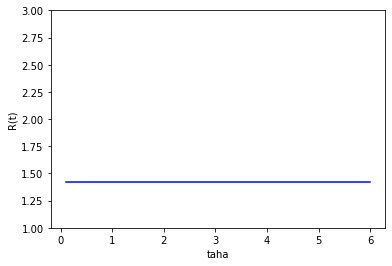

taha* = 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


R(t= 2020-06-04 ) = 1.4202658910147765 = bika*


In [24]:
# Variation of R(t) with rapport to the shape prior parameter a

# 100 linearly spaced numbers
x = np.linspace(0.1,6,100)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plot the functions
plt.plot(x, x*funcsh_inv(datyab)(x/func_sc(datyab)(x)), 'blue')

ax.set_ylim(1, 3)
ax.set(xlabel ='taha', ylabel = "R(t)")


# show the plot
plt.show()

print('taha* = 1')
print('R(t=',datyab,') =', funcsh_inv(datyab)(1/func_sc(datyab)(1)), '= bika*')


In [0]:
# Various data:

R_2_31 = [(1.31, datetime.date(2020, 5, 2)),
 (2.6100000000000003, datetime.date(2020, 5, 3)),
 (2.5100000000000002, datetime.date(2020, 5, 4)),
 (2.6100000000000003, datetime.date(2020, 5, 5)),
 (3.0100000000000002, datetime.date(2020, 5, 6)),
 (3.0100000000000002, datetime.date(2020, 5, 7)),
 (3.0100000000000002, datetime.date(2020, 5, 8)),
 (4.11, datetime.date(2020, 5, 9)),
 (3.91, datetime.date(2020, 5, 10)),
 (4.3767780913779, datetime.date(2020, 5, 11)),
 (2.9949761573723, datetime.date(2020, 5, 12)),
 (2.8361687501387802, datetime.date(2020, 5, 13)),
 (2.7958206100022545, datetime.date(2020, 5, 14)),
 (2.4796399001797464, datetime.date(2020, 5, 15)),
 (3.443033307137812, datetime.date(2020, 5, 16)),
 (3.8554240895233494, datetime.date(2020, 5, 17)),
 (4.115043463524598, datetime.date(2020, 5, 18)),
 (3.932100438170955, datetime.date(2020, 5, 19)),
 (4.506062261092727, datetime.date(2020, 5, 20)),
 (4.523619207285901, datetime.date(2020, 5, 21)),
 (4.458931264645666, datetime.date(2020, 5, 22)),
 (4.059657244369418, datetime.date(2020, 5, 23)),
 (3.756070312290585, datetime.date(2020, 5, 24)),
 (2.9652459166049185, datetime.date(2020, 5, 25)),
 (2.5824590922225963, datetime.date(2020, 5, 26)),
 (2.2148959445368077, datetime.date(2020, 5, 27)),
 (2.220846438801185, datetime.date(2020, 5, 28)),
 (2.1107872360180178, datetime.date(2020, 5, 29)),
 (2.091565444288094, datetime.date(2020, 5, 30)),
 (1.833162667249601, datetime.date(2020, 5, 31))]

R_2_31_y, R_2_31_x = [lis[0] for lis in R_2_31], [lis[1].strftime('%d/%m') for lis in R_2_31]

 # From 09/05 to 25/05 data:

R_10_25 = [(3.91, datetime.date(2020, 5, 10)),
 (5.11, datetime.date(2020, 5, 11)),
 (4.3100000000000005, datetime.date(2020, 5, 12)),
 (6.3100000000000005, datetime.date(2020, 5, 13)),
 (7.909999999999999, datetime.date(2020, 5, 14)),
 (8.01, datetime.date(2020, 5, 15)),
 (12.51, datetime.date(2020, 5, 16)),
 (14.61, datetime.date(2020, 5, 17)),
 (15.309999999999999, datetime.date(2020, 5, 18)),
 (10.618232327556617, datetime.date(2020, 5, 19)),
 (9.513276075841821, datetime.date(2020, 5, 20)),
 (7.362649508668455, datetime.date(2020, 5, 21)),
 (6.197022747127988, datetime.date(2020, 5, 22)),
 (4.992872807945991, datetime.date(2020, 5, 23)),
 (4.275090873096726, datetime.date(2020, 5, 24)),
 (3.233281463506283, datetime.date(2020, 5, 25))]

R_10_25_y, R_10_25_x = [lis[0] for lis in R_10_25], [lis[1].strftime('%d/%m') for lis in R_10_25]

# From 01/05 to 19/05 data:

R_2_19 = [(1.31, datetime.date(2020, 5, 2)),
 (2.6100000000000003, datetime.date(2020, 5, 3)),
 (2.5100000000000002, datetime.date(2020, 5, 4)),
 (2.6100000000000003, datetime.date(2020, 5, 5)),
 (3.0100000000000002, datetime.date(2020, 5, 6)),
 (3.0100000000000002, datetime.date(2020, 5, 7)),
 (3.0100000000000002, datetime.date(2020, 5, 8)),
 (4.11, datetime.date(2020, 5, 9)),
 (3.91, datetime.date(2020, 5, 10)),
 (4.3767780913779, datetime.date(2020, 5, 11)),
 (2.9949761573723, datetime.date(2020, 5, 12)),
 (2.8361687501387802, datetime.date(2020, 5, 13)),
 (2.7958206100022545, datetime.date(2020, 5, 14)),
 (2.4796399001797464, datetime.date(2020, 5, 15)),
 (3.443033307137812, datetime.date(2020, 5, 16)),
 (3.8554240895233494, datetime.date(2020, 5, 17)),
 (4.115043463524598, datetime.date(2020, 5, 18)),
 (3.932100438170955, datetime.date(2020, 5, 19))]

R_2_19_y, R_2_19_x = [lis[0] for lis in R_2_19], [lis[1].strftime('%d/%m') for lis in R_2_19]

R_10_31 = [(3.91, datetime.date(2020, 5, 10)),
 (5.11, datetime.date(2020, 5, 11)),
 (4.3100000000000005, datetime.date(2020, 5, 12)),
 (6.3100000000000005, datetime.date(2020, 5, 13)),
 (7.909999999999999, datetime.date(2020, 5, 14)),
 (8.01, datetime.date(2020, 5, 15)),
 (12.51, datetime.date(2020, 5, 16)),
 (14.61, datetime.date(2020, 5, 17)),
 (15.309999999999999, datetime.date(2020, 5, 18)),
 (10.618232327556617, datetime.date(2020, 5, 19)),
 (9.513276075841821, datetime.date(2020, 5, 20)),
 (7.362649508668455, datetime.date(2020, 5, 21)),
 (6.197022747127988, datetime.date(2020, 5, 22)),
 (4.992872807945991, datetime.date(2020, 5, 23)),
 (4.275090873096726, datetime.date(2020, 5, 24)),
 (3.233281463506283, datetime.date(2020, 5, 25)),
 (2.7206403054222768, datetime.date(2020, 5, 26)),
 (2.288389746558919, datetime.date(2020, 5, 27)),
 (2.2691088110182944, datetime.date(2020, 5, 28)),
 (2.1434017543805823, datetime.date(2020, 5, 29)),
 (2.1134368053296915, datetime.date(2020, 5, 30)),
 (1.8458912408196377, datetime.date(2020, 5, 31))]

R_10_31_y, R_10_31_x = [lis[0] for lis in R_10_31], [lis[1].strftime('%d/%m') for lis in R_10_31]

R_7_31 = [(3.0100000000000002, datetime.date(2020, 5, 7)),
 (3.0100000000000002, datetime.date(2020, 5, 8)),
 (4.11, datetime.date(2020, 5, 9)),
 (3.91, datetime.date(2020, 5, 10)),
 (5.11, datetime.date(2020, 5, 11)),
 (4.3100000000000005, datetime.date(2020, 5, 12)),
 (6.3100000000000005, datetime.date(2020, 5, 13)),
 (7.909999999999999, datetime.date(2020, 5, 14)),
 (8.01, datetime.date(2020, 5, 15)),
 (9.673905010104543, datetime.date(2020, 5, 16)),
 (9.434895735664094, datetime.date(2020, 5, 17)),
 (8.974298673063291, datetime.date(2020, 5, 18)),
 (7.0099335144792745, datetime.date(2020, 5, 19)),
 (6.939586014386592, datetime.date(2020, 5, 20)),
 (6.015102147422691, datetime.date(2020, 5, 21)),
 (5.406879378262122, datetime.date(2020, 5, 22)),
 (4.582893339447319, datetime.date(2020, 5, 23)),
 (4.050773071225689, datetime.date(2020, 5, 24)),
 (3.1176406204779346, datetime.date(2020, 5, 25)),
 (2.6610622450079715, datetime.date(2020, 5, 26)),
 (2.2565445560473574, datetime.date(2020, 5, 27)),
 (2.2480410974263254, datetime.date(2020, 5, 28)),
 (2.1290451490594084, datetime.date(2020, 5, 29)),
 (2.10373627776952, datetime.date(2020, 5, 30)),
 (1.84020545154637, datetime.date(2020, 5, 31))]

R_7_31_y, R_7_31_x = [lis[0] for lis in R_7_31], [lis[1].strftime('%d/%m') for lis in R_7_31]

R_2_4_31 = [(0.5781973392314133, datetime.date(2020, 5, 2)),
 (1.3184590290396834, datetime.date(2020, 5, 3)),
 (1.3512680351076947, datetime.date(2020, 5, 4)),
 (1.344500398714285, datetime.date(2020, 5, 5)),
 (1.7062116375196226, datetime.date(2020, 5, 6)),
 (1.6852474600242138, datetime.date(2020, 5, 7)),
 (1.7069016867267914, datetime.date(2020, 5, 8)),
 (2.184284745638741, datetime.date(2020, 5, 9)),
 (2.0519422972465433, datetime.date(2020, 5, 10)),
 (1.9472619231628072, datetime.date(2020, 5, 11)),
 (1.7161797156095633, datetime.date(2020, 5, 12)),
 (2.0604533787741683, datetime.date(2020, 5, 13)),
 (2.2183050630370245, datetime.date(2020, 5, 14)),
 (2.257005270959137, datetime.date(2020, 5, 15)),
 (3.4374353406476006, datetime.date(2020, 5, 16)),
 (3.81675228868498, datetime.date(2020, 5, 17)),
 (4.074149824078764, datetime.date(2020, 5, 18)),
 (3.657175383889672, datetime.date(2020, 5, 19)),
 (4.11796997695598, datetime.date(2020, 5, 20)),
 (3.977195312211916, datetime.date(2020, 5, 21)),
 (3.7669496445559503, datetime.date(2020, 5, 22)),
 (3.586784224574516, datetime.date(2020, 5, 23)),
 (3.0927317700251917, datetime.date(2020, 5, 24)),
 (2.421778657174041, datetime.date(2020, 5, 25)),
 (2.2455364451162585, datetime.date(2020, 5, 26)),
 (2.146484864394198, datetime.date(2020, 5, 27)),
 (2.0525876628550908, datetime.date(2020, 5, 28)),
 (1.9384632694480761, datetime.date(2020, 5, 29)),
 (1.856738763910415, datetime.date(2020, 5, 30)),
 (1.6063228647801786, datetime.date(2020, 5, 31))]

R_2_4_31_y, R_2_4_31_x = [lis[0] for lis in R_2_4_31], [lis[1].strftime('%d/%m') for lis in R_2_4_31]

R_2_4_2_6 = [(0.5781973392314133, datetime.date(2020, 5, 2)),
 (1.3184590290396834, datetime.date(2020, 5, 3)),
 (1.3512680351076947, datetime.date(2020, 5, 4)),
 (1.344500398714285, datetime.date(2020, 5, 5)),
 (1.7062116375196226, datetime.date(2020, 5, 6)),
 (1.6852474600242136, datetime.date(2020, 5, 7)),
 (1.7069016867267914, datetime.date(2020, 5, 8)),
 (2.184284745638741, datetime.date(2020, 5, 9)),
 (2.0519422972465433, datetime.date(2020, 5, 10)),
 (1.947261923162807, datetime.date(2020, 5, 11)),
 (1.7161797156095633, datetime.date(2020, 5, 12)),
 (2.0604533787741683, datetime.date(2020, 5, 13)),
 (2.2183050630370245, datetime.date(2020, 5, 14)),
 (2.257005270959137, datetime.date(2020, 5, 15)),
 (3.4374353406476006, datetime.date(2020, 5, 16)),
 (3.81675228868498, datetime.date(2020, 5, 17)),
 (4.074149824078764, datetime.date(2020, 5, 18)),
 (3.657175383889672, datetime.date(2020, 5, 19)),
 (4.1179699769559805, datetime.date(2020, 5, 20)),
 (3.977195312211916, datetime.date(2020, 5, 21)),
 (3.7669496445559503, datetime.date(2020, 5, 22)),
 (3.586784224574516, datetime.date(2020, 5, 23)),
 (3.0927317700251917, datetime.date(2020, 5, 24)),
 (2.4217786571740416, datetime.date(2020, 5, 25)),
 (2.2455364451162585, datetime.date(2020, 5, 26)),
 (2.146484864394198, datetime.date(2020, 5, 27)),
 (2.0525876628550908, datetime.date(2020, 5, 28)),
 (1.9384632694480761, datetime.date(2020, 5, 29)),
 (1.856738763910415, datetime.date(2020, 5, 30)),
 (1.6063228647801786, datetime.date(2020, 5, 31)),
 (1.4211868982553981, datetime.date(2020, 6, 1)),
 (1.3082125033617817, datetime.date(2020, 6, 2))]

R_2_4_2_6_y, R_2_4_2_6_x = [lis[0] for lis in R_2_4_2_6], [lis[1].strftime('%d/%m') for lis in R_2_4_2_6]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


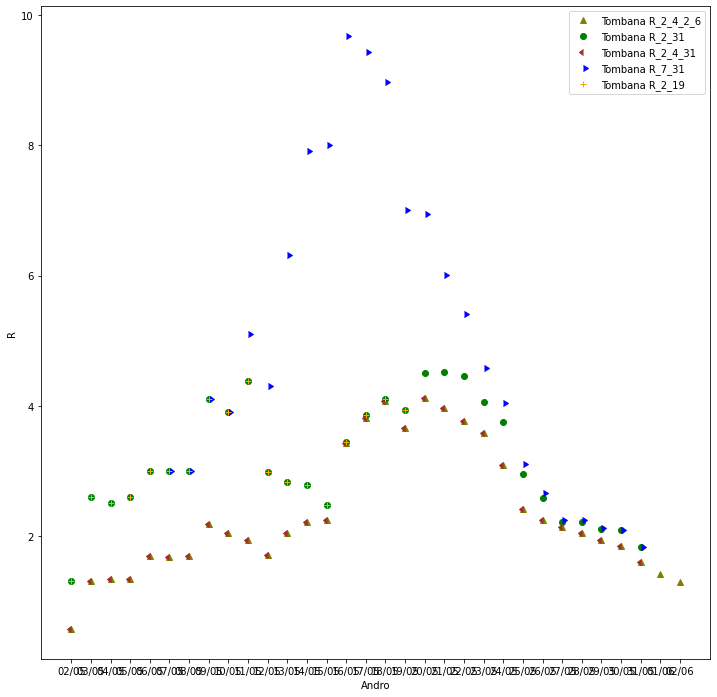

In [0]:
plt.figure(figsize=(12, 12))


# this is the order to follow for plotting
plt.plot(R_2_4_2_6_x, R_2_4_2_6_y, marker = "^", ls = 'None', color = 'olive', label='Tombana R_2_4_2_6')
plt.plot(R_2_31_x, R_2_31_y, marker = "o", ls = 'None', color = 'green', label='Tombana R_2_31')
plt.plot(R_2_4_31_x, R_2_4_31_y, marker = 8, ls = 'None', color = 'brown', label='Tombana R_2_4_31')
plt.plot(R_7_31_x, R_7_31_y, marker =9,ls = 'None', color='blue',label='Tombana R_7_31')
#plt.plot(R_10_31_x, R_10_31_y, marker =9,ls = 'None', color='blue',label='Tombana R_10_31')
#plt.plot(R_10_25_x, R_10_25_y, marker =8,ls = 'None', color='red',label='Tombana R_10_25')
plt.plot(R_2_19_x, R_2_19_y, marker = "+", ls = 'None', color='orange', label='Tombana R_2_19')

plt.xlabel('Andro')
plt.ylabel("R")
plt.legend(loc= 'best')

plt.savefig(path_to_save+'mampitahaR.eps')